In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [58]:
# Load the data
file_path = '../data/sanity_check/output/participant_data_by_disease.csv'
data = pd.read_csv(file_path)

In [59]:
# Remove records with at least one null value, including the new column
data_cleaned = data.dropna()

In [60]:
data_cleaned.head()

,eid,Age at recruitment,Sex,Cholesterol | Instance 0,LDL direct | Instance 0,HDL cholesterol | Instance 0,Triglycerides | Instance 0,Apolipoprotein A1 | Instance 0,Apolipoprotein B | Instance 0,Lipoprotein A | Instance 0,C-reactive protein | Instance 0,Glycated haemoglobin (HbA1c) | Instance 0,Creatinine | Instance 0,Cystatin C | Instance 0,Urate | Instance 0,Body mass index (BMI) | Instance 0,Smoking status | Instance 0,label
0,4848142,63,Male,4.453,2.716,0.807,4.649,1.3430,0.914,49.21,4.83,51.6,86.3,1.062,326.3,32.0017,Current,Heart Disease
1,3336283,63,Female,4.499,2.808,1.031,1.709,1.1217,0.887,28.22,0.55,31.8,62.6,0.915,193.3,28.2072,Never,Heart Disease
4,2765531,66,Female,4.788,3.051,0.960,2.275,1.1838,0.990,8.40,2.76,35.2,78.2,1.083,327.8,29.0311,Previous,Heart Disease
27,1218833,64,Female,4.268,2.678,0.791,2.569,1.0288,0.932,25.00,4.59,80.9,75.5,1.170,291.7,32.1427,Previous,Heart Disease
28,3382405,62,Female,5.551,3.732,1.097,1.992,1.3787,1.147,161.10,7.31,54.8,45.9,0.977,346.2,38.2150,Previous,Heart Disease


In [61]:
# Remove specified columns
columns_to_remove = ['eid', 'Age at recruitment', 'Sex', 'Body mass index (BMI) | Instance 0', 'Smoking status | Instance 0']
data_cleaned = data_cleaned.drop(columns=columns_to_remove, errors='ignore')

# Split data by label
heart_disease_data = data_cleaned[data_cleaned['label'] == 'Heart Disease']
healthy_data = data_cleaned[data_cleaned['label'] == 'Healthy']

In [52]:
# Function to preprocess and apply PCA
def apply_pca(data, label, color):
    # Separate features (excluding the label column)
    features = data.drop(columns=['label'])

    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

    # Plotting
    plt.scatter(pca_df['PC1'], pca_df['PC2'], label=label, c=color, alpha=0.5)

    # Return explained variance ratio for reference
    return pca.explained_variance_ratio_

In [53]:
# Function to preprocess and apply PCA
def apply_pca_3d(data, label):
    # Separate features (excluding the label column)
    features = data.drop(columns=['label'])

    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Apply PCA (now with 3 components)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_features)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

    # Return pca_df and explained variance ratio
    return pca_df, pca.explained_variance_ratio_

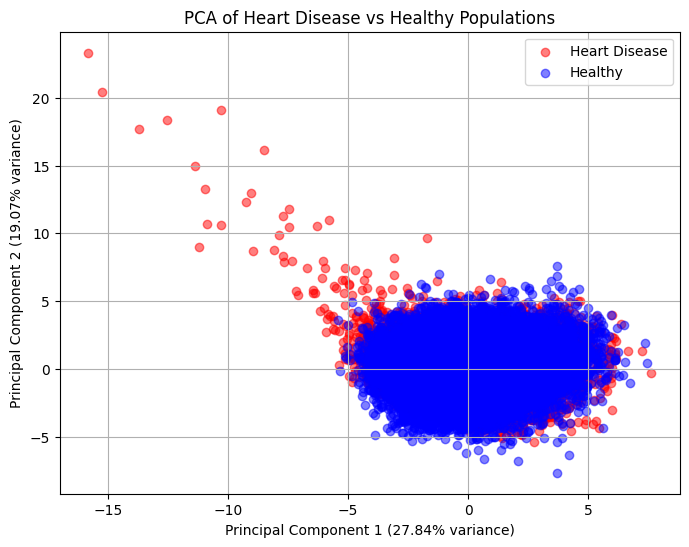

In [54]:
# Apply PCA to both groups
plt.figure(figsize=(8, 6))
variance_ratio_heart = apply_pca(heart_disease_data, 'Heart Disease', 'red')
variance_ratio_healthy = apply_pca(healthy_data, 'Healthy', 'blue')

# Plot customization
plt.title('PCA of Heart Disease vs Healthy Populations')
plt.xlabel(f'Principal Component 1 ({variance_ratio_heart[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({variance_ratio_heart[1]:.2%} variance)')
plt.legend()
plt.grid(True)
plt.show()



In [55]:
# Print explained variance ratios
print(f"Heart Disease - Explained Variance Ratio: PC1: {variance_ratio_heart[0]:.2%}, PC2: {variance_ratio_heart[1]:.2%}")
print(f"Healthy - Explained Variance Ratio: PC1: {variance_ratio_healthy[0]:.2%}, PC2: {variance_ratio_healthy[1]:.2%}")

Heart Disease - Explained Variance Ratio: PC1: 27.84%, PC2: 19.07%
Healthy - Explained Variance Ratio: PC1: 26.68%, PC2: 22.89%


In [56]:

# Apply PCA to both groups
pca_df_heart, variance_ratio_heart = apply_pca_3d(heart_disease_data, 'Heart Disease')
pca_df_healthy, variance_ratio_healthy = apply_pca_3d(healthy_data, 'Healthy')

# Create interactive 3D scatter plot
fig = go.Figure()

# Add Heart Disease data
fig.add_trace(go.Scatter3d(
    x=pca_df_heart['PC1'],
    y=pca_df_heart['PC2'],
    z=pca_df_heart['PC3'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.6),
    name='Heart Disease'
))

# Add Healthy data
fig.add_trace(go.Scatter3d(
    x=pca_df_healthy['PC1'],
    y=pca_df_healthy['PC2'],
    z=pca_df_healthy['PC3'],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.6),
    name='Healthy'
))

# Update layout
fig.update_layout(
    title='3D PCA of Heart Disease vs Healthy Populations',
    scene=dict(
        xaxis_title=f'PC1 ({variance_ratio_heart[0]:.2%} variance)',
        yaxis_title=f'PC2 ({variance_ratio_heart[1]:.2%} variance)',
        zaxis_title=f'PC3 ({variance_ratio_heart[2]:.2%} variance)'
    ),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()

TypeError: apply_pca_3d() missing 1 required positional argument: 'color'